In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import glob
import sys
import h3

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
import geopandas as gpd
import seaborn as sns
# use the husl color palette for age
colorls = sns.color_palette("husl", 3)
# plot the color
# convert to rgb color
color_ls_rgb = [(int(x[0]*255), int(x[1]*255), int(x[2]*255)) for x in colorls]

In [47]:
ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
FOLDER_TO_SAVE = "{ROOTFOLDER}/_transformed/age_gender_v2/{cityabbr}"
FILE_TO_SAVE = "{ROOTFOLDER}/_transformed/age_gender_v2/{cityabbr}/n={part}_objects.parquet"
# FILE_TO_SAVE = "{ROOTFOLDER}/_transformed/age_gender/{cityabbr}/n={part}_objects.parquet"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
PATH_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_path.csv"
FILE_TO_EXPORT = "{ROOTFOLDER}/_curated/c_age_gender/{cityabbr}.parquet"
FOLDER_TO_EXP = f"{ROOTFOLDER}/_curated/c_age_gender"
if not os.path.exists(FOLDER_TO_EXP):
    os.makedirs(FOLDER_TO_EXP)

In [48]:

object_age_dict = {
                    'female18-60':'18-60', 
                'male18-60':'18-60', 
                'male-60':'60+', 
                'male-18':'18-', 
                'female-60':'60+',
                'female-18':'18-'
                }

def get_hex_basics(city_abbr, res):
    # read all object files and concat them into one df
    df_pano = pd.read_csv(PANO_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
    df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
    # only keep the panoid that has a path
    df_pano_inner = df_pano[
        df_pano["panoid"].isin(df_path["panoid"].unique())
    ].reset_index(drop=True)
    print(df_pano_inner.shape[0], "out of ", df_pano.shape[0], "panoids have path")
    df_pano_inner["hex_id"] = df_pano_inner.apply(
        lambda x: h3.geo_to_h3(x["lat"], x["lon"], res), axis=1
    )

    # keep these hex
    df_all_keep = df_pano_inner[(df_pano_inner["year"] >= 2014)
    ].reset_index(drop=True)
    print(df_all_keep.shape[0], "panoids are kept")
    # assign the year_group; skip for now
    
    # get number of panoid per hex per year
    df_all_keep_hex = (
        df_all_keep.groupby(["hex_id", "year"])["panoid"]
        .nunique()
        .reset_index(name="panoid_n")
    )
    return df_all_keep_hex, df_all_keep


def load_results(cityabbr):
    
    df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr))
    df_path['img'] = df_path['path'].apply(lambda x: x.split("/")[-1])
    
    # process the prediction results
    objfiles = glob.glob(
        FOLDER_TO_SAVE.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr) + "/*.parquet"
    )
    if len(objfiles) == 0:
        print("No object files found for", cityabbr)
    df = pd.concat([pd.read_parquet(f) for f in objfiles])
    df_path = df_path.merge(df, on='img', how='inner')
    return df,df_path
    
def get_confidence(df, conf):
    df_con = df[df['confidence']>=conf].reset_index(drop=True)
    df_con['object_name'] = df_con['object_name'].apply(lambda x: x.lower())
    df_con['gender'] = df_con['object_name'].apply(lambda x: "female" if "female" in x.lower() else "male")
    df_con['age'] = df_con['object_name'].apply(lambda x: object_age_dict[x.lower()] if x.lower() in object_age_dict else "unknown")
    # find an image with most male-60
    df_summary = df_con.groupby(['img','gender', 'age']).size().reset_index().pivot(
        index='img', columns = ['gender', 'age'], values=0
    ).fillna(0)
    df_summary.columns = ['_'.join(x) for x in df_summary.columns]
    df_summary['pedestrian_count'] = df_summary.sum(axis=1)
    df_summary = df_summary.reset_index()
    df_summary['panoid'] = df_summary['img'].apply(lambda x: x[:22])
    df_summary_pano = df_summary.groupby(['panoid']).sum().reset_index()
    return df_summary, df_summary_pano

def get_result(city):
    cityabbr = city.lower().replace(" ", "")
    df, df_path = load_results(cityabbr)
    alldf = []
    for res in [8,9]:
        for conf in [0.2,0.5, 0.7, 0.8]:
            df_summary, df_summary_pano = get_confidence(df, conf)
            df_all_keep_hex, df_all_keep = get_hex_basics(cityabbr, res)
            df_summary_merged = df_summary_pano.merge(df_all_keep, on='panoid', how='inner')
            df_summary_merged['male_total'] = df_summary_merged[['male_18-60', 'male_60+','male_18-']].sum(axis=1)
            df_summary_merged['female_total'] = df_summary_merged[['female_18-60', 'female_60+','female_18-']].sum(axis=1)
            df_summary_merged['male_ratio'] = df_summary_merged['male_total']/df_summary_merged['pedestrian_count']
            df_summary_merged['female_ratio'] = df_summary_merged['female_total']/df_summary_merged['pedestrian_count']
            df_summary_hex = df_summary_merged.groupby(['hex_id', 'year'])[['male_18-60', 'male_60+', 'female_60+', 'female_18-60',
                'male_18-', 'female_18-','pedestrian_count']].sum().reset_index()
            df_summary_hex_pano = df_summary_merged.groupby(['hex_id','year']).agg({'panoid':'nunique'}).reset_index()
            df_summary_hex_pano.rename(columns={'panoid':'panoid_n_with_person'}, inplace=True)

            df_summary_final = df_all_keep_hex.merge(
                df_summary_hex, on=['hex_id', 'year'], how='left'
            ).merge(
                df_summary_hex_pano, on=['hex_id','year'], how='left'
            ).fillna(0)
            df_summary_final['res'] = res
            df_summary_final['conf'] = conf
            alldf.append(df_summary_final)
    alldf = pd.concat(alldf).reset_index(drop=True)
    alldf.to_parquet(FILE_TO_EXPORT.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr), index=False)
    return alldf

In [75]:
city = "Nairobi"
cityabbr = city.lower().replace(" ", "")
df, df_path = load_results(cityabbr)

In [76]:
import gc
gc.collect()

0

In [77]:
df_summary, df_summary_pano = get_confidence(df, 0.5)
final_summary = df_summary_pano.sum().reset_index()
final_summary

,index,0
0,panoid,--6rir7WBjJoKcL5UgHzFw--7W71-6PssCAnX0cPND0A--...
1,img,--6rir7WBjJoKcL5UgHzFw_0.jpg--7W71-6PssCAnX0cP...
2,male_18-60,101484.0
3,male_18-,4484.0
4,female_18-60,43211.0
5,female_18-,2902.0
6,male_60+,2846.0
7,female_60+,1366.0
8,pedestrian_count,156293.0


# Visualize the example for validation

In [56]:
df['panoid'] = df['img'].apply(lambda x: x[:22])

In [57]:
sample_img = df_summary.sort_values('male_60+', ascending=False)['img'].values[0]
print(sample_img)
# find the image path
df_path_sel = df_path[df_path['img']==sample_img].reset_index(drop=True)
print(df_path_sel['path'].values[0])

UpxUVsS0ZltLSmGXNvv4uQ_90.jpg
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/taipei/img_rgb/b_1/c/8/UpxUVsS0ZltLSmGXNvv4uQ_90.jpg


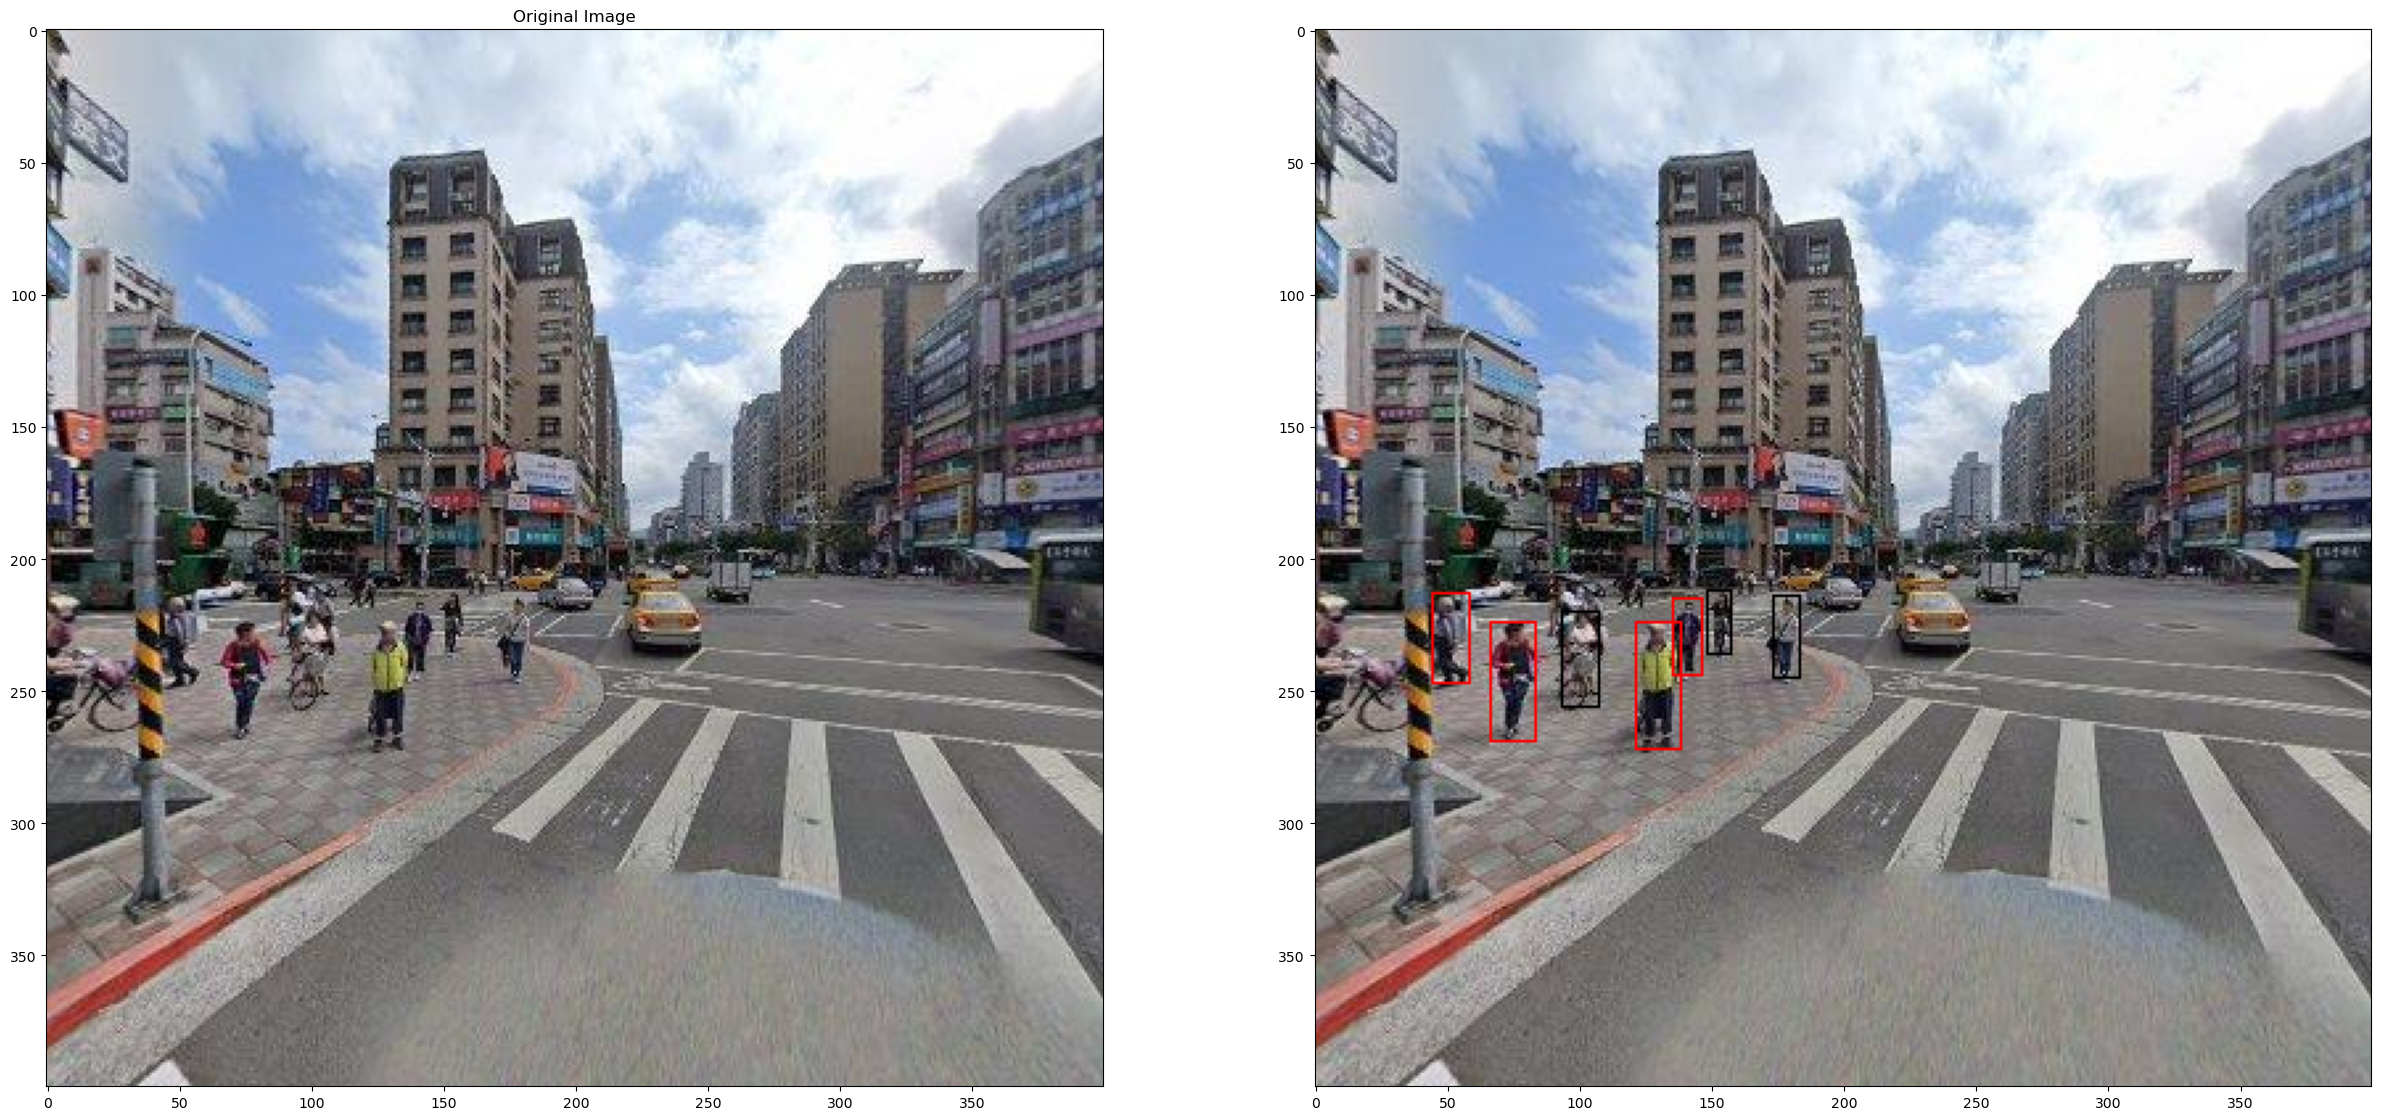

In [58]:
import cv2
import matplotlib.pyplot as plt
img_base = cv2.imread(df_path_sel['path'].values[0])
img_rgb = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
predictions = df[df['img']==sample_img].reset_index(drop = True)
for pred in predictions.iterrows():
    pred = pred[1]
    x1, y1, x2, y2 = pred['x1'], pred['y1'], pred['x2'], pred['y2']
    # if pred['gender']=='female':
    if pred['object_name']=='Male-60':
        cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 1) # red
    else:
        cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 1) # black
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
ax[0].imshow(cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[1].imshow(img_rgb)